In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../rdtools')
from system_analysis import SystemAnalysis
import pandas as pd
import numpy as np
import pvlib 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,15)


In [3]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv(file_name)
try:
    df.columns = [col.decode('utf-8') for col in df.columns]
except AttributeError:
    pass  # Python 3 strings are already unicode literals
df = df.rename(columns = {
    u'12 BP Solar - Active Power (kW)':'power',
    u'12 BP Solar - Wind Speed (m/s)': 'wind',
    u'12 BP Solar - Weather Temperature Celsius (\xb0C)': 'Tamb',
    u'12 BP Solar - Global Horizontal Radiation (W/m\xb2)': 'ghi',
    u'12 BP Solar - Diffuse Horizontal Radiation (W/m\xb2)': 'dhi'
})

# Specify the Metadata
meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "tempco": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback'}

df.index = pd.to_datetime(df.Timestamp)
# TZ is required for irradiance transposition
df.index = df.index.tz_localize(meta['timezone'], ambiguous = 'infer') 

# Explicitly trim the dates so that runs of this example notebook 
# are comparable when the sourec dataset has been downloaded at different times
df = df['2008-11-11':'2017-05-15']

# Chage power from kilowatts to watts
df['power'] = df.power * 1000.0

# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# Calculate POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.apparent_zenith))
poa = pvlib.irradiance.get_total_irradiance(meta['tilt'], meta['azimuth'], sun['apparent_zenith'],
                                                             sun['azimuth'], df['dni'], df['ghi'],
                                                             df['dhi'], albedo=0.25, model='isotropic')
df['poa'] = poa['poa_global']

In [4]:
sa = SystemAnalysis(
    pv=df['power'], 
    poa=df['poa'], 
    ambient_temperature=df['Tamb'],
    gamma_pdc=meta['tempco'],
    #interp_freq=freq,
    #max_timedelta=pd.to_timedelta('15 minutes'),
    pvlib_location=loc,
    windspeed=df['wind'],
    pv_tilt=meta['tilt'],
    pv_azimuth=meta['azimuth'],
    #temperature_model=meta['temp_model'],
    #albedo=0.25
)

DEBUG: registering plugin pvwatts: ['poa', 'sensor_cell_temperature', 'gamma_pdc', 'g_ref', 't_ref', 'system_size']->['pvwatts_expected_power']
DEBUG: registering plugin sapm: ['pvlib_localized_pvsystem', 'dni', 'ghi', 'dhi', 'ambient_temperature', 'windspeed']->['sapm_expected_power']
DEBUG: registering plugin sensor_expected_power: ['dc_model']->['sensor_expected_power']
DEBUG: registering plugin sensor_normalize: ['pv', 'sensor_expected_power', 'system_size']->['sensor_normalized']
DEBUG: registering plugin get_times: ['pv']->['times']
DEBUG: registering plugin get_solarposition: ['pvlib_location', 'times']->['solar_position']
DEBUG: registering plugin get_clearsky_irradiance: ['pvlib_location', 'times']->['clearsky_irradiance']
DEBUG: registering plugin get_clearsky_poa: ['pv_tilt', 'pv_azimuth', 'albedo', 'solar_position', 'clearsky_irradiance']->['clearsky_poa_unscaled']
DEBUG: registering plugin rescale_clearsky_poa: ['clearsky_poa_unscaled', 'poa']->['clearsky_poa']
DEBUG: regi

C:\Users\KANDERSO\Software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\KANDERSO\Software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


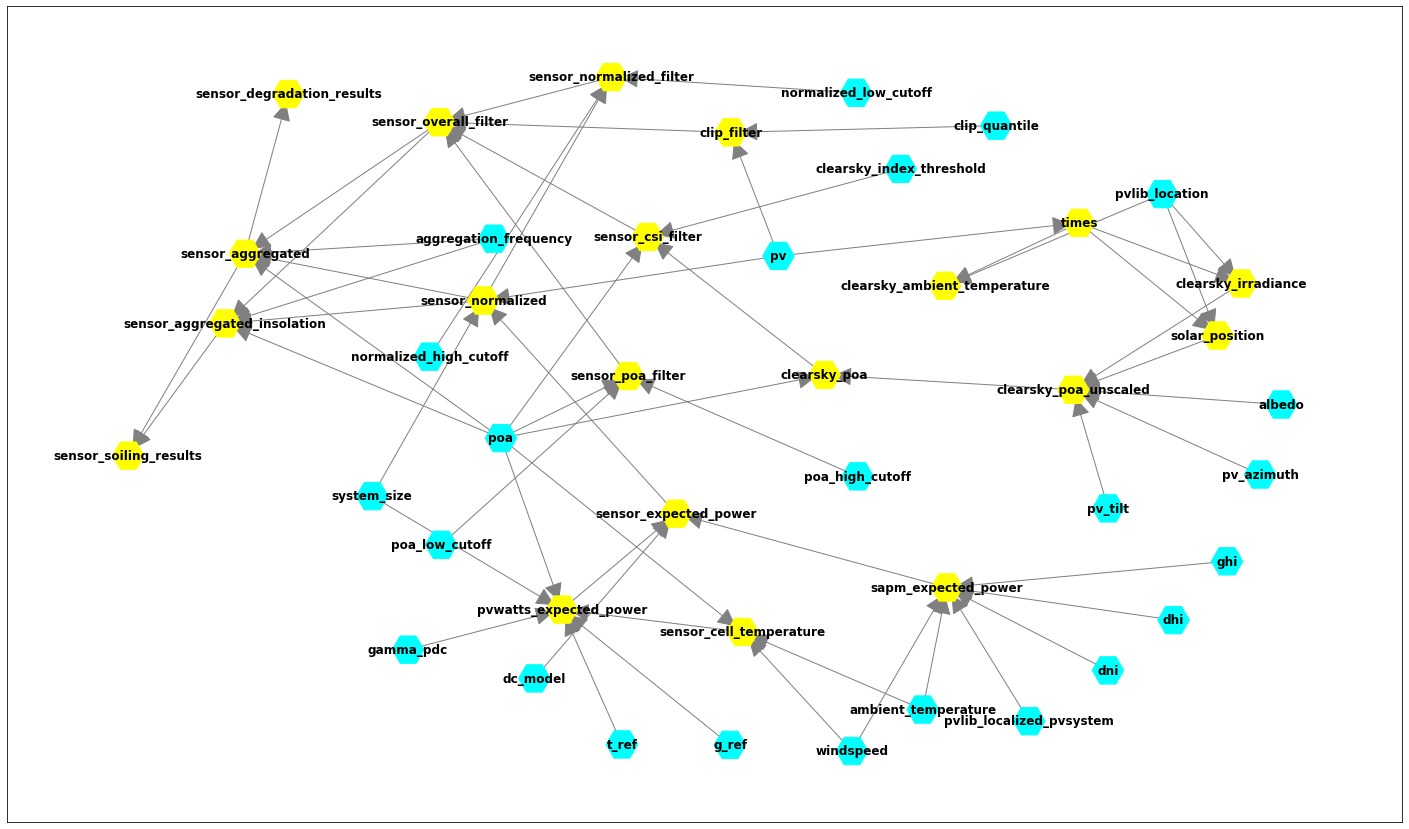

In [5]:
sa.diagram()

DEBUG: checking prerequisites for sensor_aggregate: ['sensor_normalized', 'poa', 'sensor_overall_filter', 'aggregation_frequency']
DEBUG: requirement already satisfied: sensor_normalized
DEBUG: requirement already satisfied: poa
DEBUG: calculating requirement sensor_overall_filter with provider sensor_filter
DEBUG: checking prerequisites for sensor_filter: ['sensor_normalized_filter', 'sensor_poa_filter', 'clip_filter', 'sensor_csi_filter']
DEBUG: calculating requirement sensor_normalized_filter with provider normalized_filter
DEBUG: checking prerequisites for normalized_filter: ['sensor_normalized', 'normalized_low_cutoff', 'normalized_high_cutoff']
DEBUG: requirement already satisfied: sensor_normalized
DEBUG: requirement already satisfied: normalized_low_cutoff
DEBUG: requirement already satisfied: normalized_high_cutoff
DEBUG: calling normalized_filter with requires=['sensor_normalized', 'normalized_low_cutoff', 'normalized_high_cutoff'], optional=[], and kwargs=[]
DEBUG: calculati

C:\Users\KANDERSO\Software\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


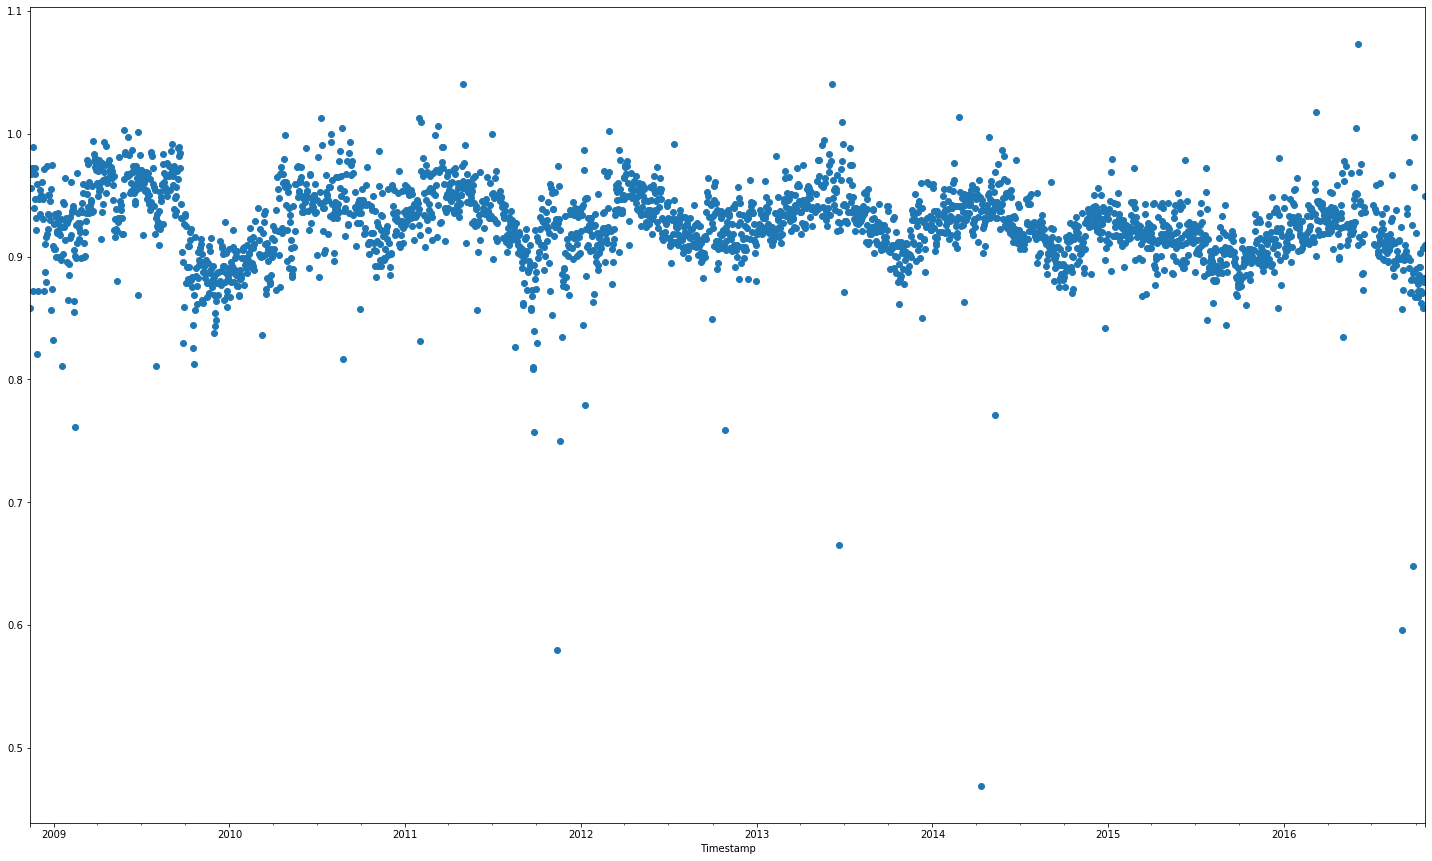

In [7]:
agg, agg_insol = sa.calculate('sensor_aggregated')
agg.plot(ls='', marker='o')

In [8]:
yoy = sa.calculate('sensor_degradation_results')
yoy['p50_rd']

DEBUG: checking prerequisites for sensor_yoy_degradation: ['sensor_aggregated']
DEBUG: requirement already satisfied: sensor_aggregated
DEBUG: calling sensor_yoy_degradation with requires=['sensor_aggregated'], optional=[], and kwargs=[]


-0.3904133008163946

In [9]:
srr = sa.calculate('sensor_soiling_results')

DEBUG: checking prerequisites for sensor_srr_soiling: ['sensor_aggregated', 'sensor_aggregated_insolation']
DEBUG: requirement already satisfied: sensor_aggregated
DEBUG: requirement already satisfied: sensor_aggregated_insolation
DEBUG: calling sensor_srr_soiling with requires=['sensor_aggregated', 'sensor_aggregated_insolation'], optional=[], and kwargs=[]


IndexError: index 0 is out of bounds for axis 0 with size 0

Text(0, 0.5, 'PV Energy (Wh/timestep)')

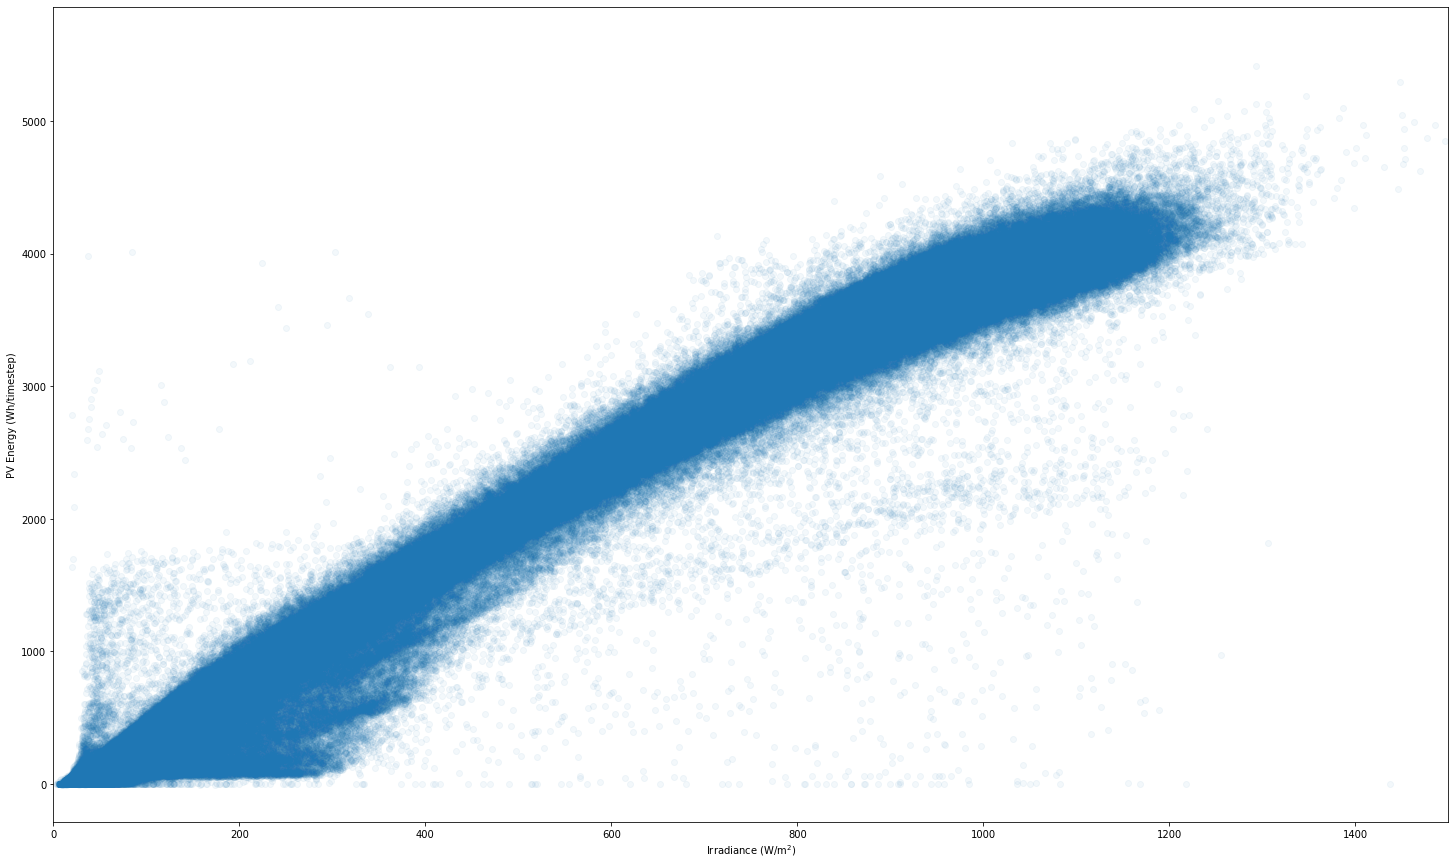

In [10]:
poa = sa.dataset['poa']
power = sa.dataset['pv']

to_plot = pd.merge(pd.DataFrame(poa), pd.DataFrame(power), left_index=True, right_index=True)

fig, ax = plt.subplots()
ax.plot(to_plot.iloc[:, 0], to_plot.iloc[:, 1], 'o', alpha=.05,)
ax.set_xlim(0, 1500)
ax.set_xlabel('Irradiance (W/m$^2$)')
ax.set_ylabel('PV Energy (Wh/timestep)')